In [24]:
import pandas as pd

df = pd.read_csv("../data/data_raw.csv")
df = df.drop('id', 1)

y = df['diagnosis']
X = df.loc[:, df.columns != 'diagnosis']

In [25]:
import pickle

file = open('../results/final_models.save', 'rb')
final_models = pickle.load(file)
file.close()

file = open('../data/final_test_data.save', 'rb')
final_data = pickle.load(file)
file.close()

file = open('../data/final_train_data.save', 'rb')
final_train = pickle.load(file)
file.close()

In [26]:
y_tests = []
y_tests_pred = []
y_tests_prob = []
coefs_list = []


for i in range(len(final_data)):
    
    X_test, y_test = final_data[i]
    clf = final_models[i]
    
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test)
    
    coefs = clf.coef_
    
    y_tests.append(y_test)
    y_tests_pred.append(y_test_pred)
    y_tests_prob.append(y_test_prob)
    coefs_list.append(coefs)

In [27]:
from sklearn.metrics import accuracy_score
from statistics import mean, stdev

baseline_accuracies = [len([y for y in Y if y ==0])/len(Y) for Y in y_tests]
accuracy_scores = [accuracy_score(y_tests[i], y_tests_pred[i]) for i in range(len(y_tests))]

print(f"{mean(accuracy_scores)} ± {stdev(accuracy_scores)}")
print(f"{mean(baseline_accuracies)} ± {stdev(baseline_accuracies)}")

0.9769298245614035 ± 0.014414021128271526
0.6191228070175439 ± 0.04044246053784698


In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

cms = [confusion_matrix(y_tests[i], y_tests_pred[i]) for i in range(len(y_tests))]

tn = sum([a[0,0] for a in cms]) / len([a[0,0] for a in cms])
fp = sum([a[0,1] for a in cms]) / len([a[0,1] for a in cms])
fn = sum([a[1,0] for a in cms]) / len([a[1,0] for a in cms])
tp = sum([a[1,1] for a in cms]) / len([a[1,1] for a in cms])

mean_confusion_matrix = np.array([[tn, fp], [fn, tp]])
cm = mean_confusion_matrix.astype('float') / mean_confusion_matrix.sum(axis=1)[:, np.newaxis]
cm

array([[0.98923208, 0.01076792],
       [0.04306771, 0.95693229]])

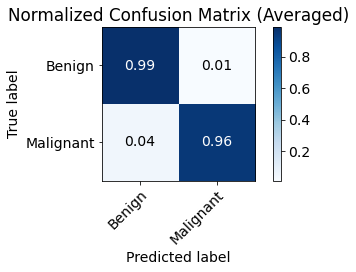

In [37]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=['Benign','Malignant'], yticklabels=['Benign','Malignant'],
       title='Normalized Confusion Matrix (Averaged)',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig('../figures/confusion_matrix.png', dpi=300, format='png')
plt.show()

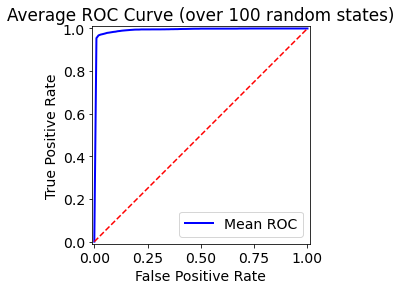

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
import numpy as np

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 101)

for y_test, y_test_prob in zip(y_tests, y_tests_prob):
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])
    
#     plt.plot(fpr, tpr, 'k', alpha=0.09, lw=0.5)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = np.maximum(mean_tprs - std, 0)

plt.plot(base_fpr, mean_tprs, 'b', label="Mean ROC", lw=2)
# plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.5, label="confidence band")

plt.plot([0, 1], [0, 1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title("Average ROC Curve (over 100 random states)")
plt.savefig('../figures/ROC_curve.png', dpi=300, format='png')
plt.show()

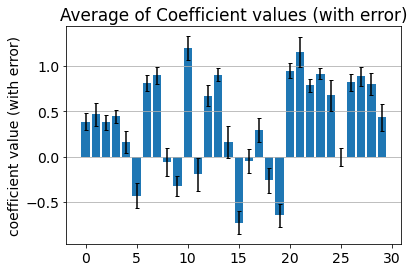

In [31]:
coefs_list_1 = np.array([a[0] for a in coefs_list])
mean_coefs = np.mean(coefs_list_1,axis=0)
std_coefs = np.std(coefs_list_1,axis=0)

plt.bar(np.arange(X.shape[1]), mean_coefs, yerr=std_coefs, capsize=2)
# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("coefficient value (with error)")
plt.title("Average of Coefficient values (with error)")
plt.savefig('../figures/all_coefs.png', dpi=300, format='png')
plt.grid(axis='y')
plt.show()

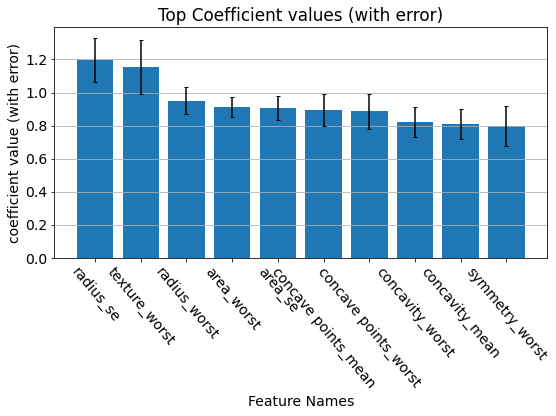

In [36]:
from operator import itemgetter

abs_coefs = np.absolute(mean_coefs)
abs_thetas_tuple = [(i,coef) for i,coef in enumerate(abs_coefs)]

results = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)

nr_coefs = 10

top_coefs_result = [(result, X.columns[result[0]]) for result in results][:nr_coefs]
# for result in results:
#     print(result, X.columns[result[0]])
top_coefs = [mean_coefs[t[0][0]] for t in top_coefs_result]
top_features = [t[1] for t in top_coefs_result]
std_top_coefs = [std_coefs[t[0][0]] for t in top_coefs_result]

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.bar(np.arange(nr_coefs), top_coefs, yerr=std_top_coefs, capsize=2)
plt.xticks(np.arange(nr_coefs),top_features)
plt.ylabel("coefficient value (with error)")
plt.title("Top Coefficient values (with error)")
plt.xticks(rotation=-50)
plt.grid(axis='y')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.savefig('../figures/top_coefs.png', dpi=300, format='png')
plt.show()

In [33]:
from sklearn.inspection import permutation_importance
import matplotlib.pylab as plt
from tqdm import tqdm

scores_top = []
ftr_names = X.columns

for i in tqdm(range(len(final_data))):

    X_test, y_test = final_data[i]
    clf = final_models[i]
    
    result = permutation_importance(clf, X_test, y_test, n_repeats=10,random_state=42*i,scoring='accuracy',n_jobs=-1)
    
    scores = result.importances
    
    scores_top.append(scores)

100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


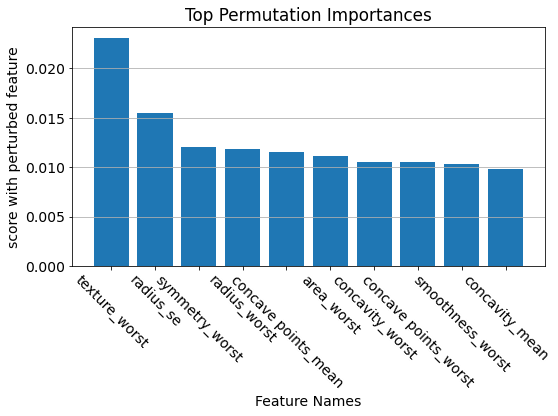

In [38]:
nr_ftrs = 10

scores = np.mean(scores_top, axis=0)
sorted_indcs = np.argsort(np.mean(scores,axis=1))
mean_permutation_scores = np.mean(scores, axis=1)
top_mean_permutation_scores = mean_permutation_scores[sorted_indcs[-nr_ftrs:]][::-1]
top_ftr_names = ftr_names[sorted_indcs[-nr_ftrs:]][::-1]


plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
# plt.boxplot(scores[sorted_indcs[-nr_ftrs:]].T,labels=ftr_names[sorted_indcs[-nr_ftrs:]],vert=False)
plt.bar(range(nr_ftrs), top_mean_permutation_scores)
plt.xticks(range(nr_ftrs),top_ftr_names)
plt.title("Top Permutation Importances")
plt.ylabel('score with perturbed feature')
plt.xlabel('Feature Names')
plt.xticks(rotation=-45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../figures/perm_test.png', dpi=300, format='png')
plt.show()

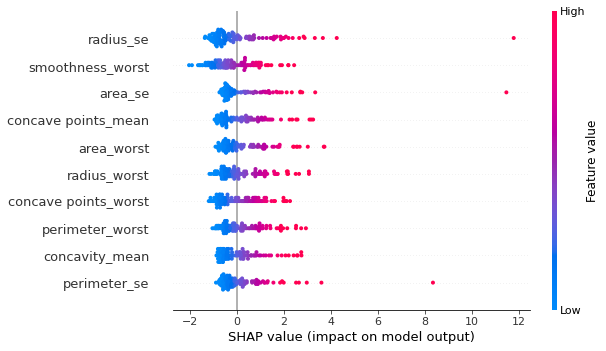

In [15]:
import shap

clf = final_models[0]
X_test, y_test = final_data[0]
X_train, y_train = final_train[0]

explainer = shap.LinearExplainer(clf, X_train)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names = X.columns, max_display=10, 
                  title="SHAP Summary Plot for Random State 1")

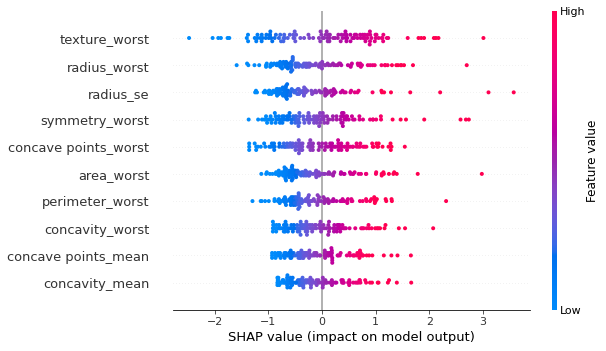

In [16]:
clf = final_models[50]
X_test, y_test = final_data[50]
X_train, y_train = final_train[50]

explainer = shap.LinearExplainer(clf, X_train)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names = X.columns, max_display=10, 
                  title="SHAP Summary Plot for Random State 1")

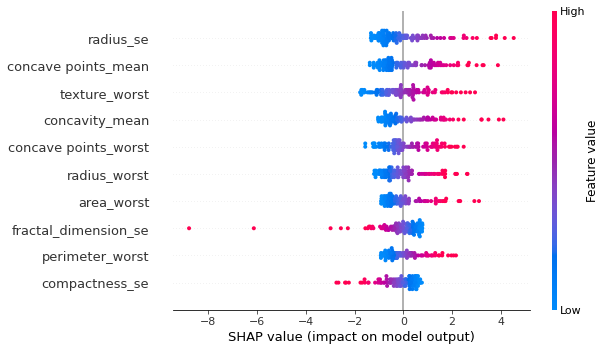

In [17]:
clf = final_models[75]
X_test, y_test = final_data[75]
X_train, y_train = final_train[75]

explainer = shap.LinearExplainer(clf, X_train)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names = X.columns, max_display=10, 
                  title="SHAP Summary Plot for Random State 1")